# LDA and QDA Classifiers

## Preliminaries

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


import sys
sys.path.append("../..")
from E4525_ML import plots
from E4525_ML import samples

### Random Seed

In [2]:
seed=23863
np.random.seed(seed)

## Generate Mixture of Gaussians Sample Data 

We will generate data over a true **mixed gaussian** distribution
$$
    p(y=k) = \pi^0_k
$$
And
$$
    p(x| y=k) = \mathcal{N}(x;\mu^0_k,\Lambda^0_k)
$$
Where $x\in \mathbb{R}^D$ for $D=2$ and $y$ can belong to $K=3$ classes, $\mu^0_k$ is a $D$-dimensional vector, and $\Lambda^0_k$ is a $D\times D$ positive definite symmetric matrix.

The marginal distribution of $x$ is then

$$
    p(x) = \sum_k p(x|y=k)p(y=k) = \sum_k \mathcal{N}(x;\mu^0_k,\Lambda^0_k) \pi_k
$$

In [3]:
pi0=np.array([0.5,0.25,0.25])

We define the class conditional means
$$
    \mu^0_{k,d}
$$
and variances
$$
    \Lambda^0_{k,d,d'}
$$
where $\Lambda^0$ is symmetric on the last two indexes 
$$
    \Lambda^0_{k,d,d'} = \Lambda^0_{k,d',d}
$$

In [41]:
mu0=np.array([[0.0,0.0],
              [2.0,2.0],
              [2.0,-2.0]
             ]
            )

sigma0=np.array(
    [
        [ [1.0, 0.0],
          [0.0, 1.0]
        ],
        [ [ 1.0, -.75],
          [-0.75, 1.0]
        ],
         [ [ 1.0, 0.75],
          [  0.75, 1.0]
        ]
    ]
)

We will generate $N$ samples

In [5]:
N_samples=20

To generate $X$ we  generate  auxiliary variables $X_{k,i,d}$ for each one of the possible $k$ classes ( $k=1,\dots,K$ the number of classes, $i=1,\dots,N$, the number of samples,  and $d=1,\dots,D$ the number of dimensions of $X$)

$$
    X_{i,k,d} \sim \mathcal{N}(\mu^0_k,\Lambda^0_k)
$$
and them we multiply by the one hot encoding $Z$ of $Y$
$$
    X_{i,d} = \sum_k X_{k,i,d} Z_{i,k}
$$

In [42]:
# returns X, and Z the one-hot encoding of Y
def gaussian_mixture(N_samples,pi, mu,sigma):
    K,D=mu.shape
    # We generate Y first, but as a one-hot encoded representation Z
    # Z has multinomial with K possible classes
    # Z is N x K 
    Z=np.random.multinomial(1,pi,N_samples)
    gaussians=np.empty((K,N_samples,D))
    for k in range(K):
          gaussian=np.random.multivariate_normal(mu[k],sigma[k],size=N_samples)
          gaussians[k]=gaussian
    # Z.T[...,np.newaxis] will be K x N_samples x 1
    # Gaussian is                 K x N_samples x D
    # P_{k,i,d } =  Z_{i,k} * G_{k,i,d}
    prod=Z.T[...,np.newaxis]*gaussians
    X=np.sum(prod,axis=0)
    return X,Z

In [7]:
X,Z=samples.gaussian_mixture(N_samples,pi0,mu0,sigma0)
X_test,Z_test=gaussian_mixture(N_samples,pi0,mu0,sigma0)

In [8]:
# generate class Y from one-hot encoding
Y=Z.argmax(axis=1)
Y_test=Z_test.argmax(axis=1)

In [9]:
X.shape,X_test.shape

((20, 2), (20, 2))

### Visualize Input Data distribution

We separate X by class to plot them separately

In [10]:
x0=X[Z[:,0]==1]
x1=X[Z[:,1]==1]
x2=X[Z[:,2]==1]

In [11]:
def plot_ellipse(splot, mean, cov, color):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell1 = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor=color,
                              linewidth=2, zorder=2)
    ell1.set_clip_box(splot.bbox)
    ell1.set_alpha(0.2)
    
    ell2 = mpl.patches.Ellipse(mean, 4 * v[0] ** 0.5, 4 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor=color,
                              linewidth=2, zorder=2)
    ell2.set_clip_box(splot.bbox)
    ell2.set_alpha(0.05)
    splot.add_artist(ell1)
    splot.add_artist(ell2)
    splot.set_xticks(())
    splot.set_yticks(())

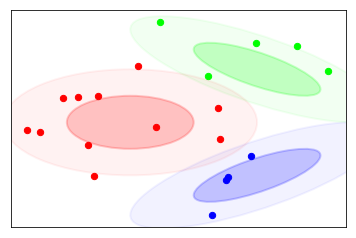

In [12]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)

ax1.scatter(x0[:,0],x0[:,1],c="#FF0000", s=40)
ax1.scatter(x1[:,0],x1[:,1],c="#00FF00", s=40)
ax1.scatter(x2[:,0],x2[:,1],c="#0000FF", s=40)
plot_ellipse(ax1,mu0[0],sigma0[0],"#FF0000")
plot_ellipse(ax1,mu0[1],sigma0[1],"#00FF00")
plot_ellipse(ax1,mu0[2],sigma0[2],"#0000FF")

## LDA and QDA Mixture Estimates

### LDA Gaussian Mixture Estimates

For LDA we need to estimate the per class marginal distributions
$$
    \hat{\pi}_k = \frac{\hat{N}_k}{N} = \frac{ \sum_i z_{i,k}}{N}
$$
the per class mean
$$
    \mu_{k,d} = \frac{1}{\hat{N}_k}\sum_i z_{i,k}x_{i,d} 
$$
and the shared covariance matrix
$$
    \Lambda_{d,d'} = \frac{1}{N} \sum_k\sum_i z_{i,k}( x_{i,d} -\mu_{k,d})( x_{i,d'} -\mu_{k,d'})
$$

In [13]:
def LDA_estimate(X,Z):
    counts=Z.sum(axis=0)
    pi=counts/len(X)
    ZX=Z[:,:,np.newaxis]*X[:,np.newaxis,:]
    mu=np.sum(ZX,axis=0)/counts[:,np.newaxis]
    dZX=ZX-Z[:,:,np.newaxis]*mu[np.newaxis,:,:]
    dZX2=dZX[:,:,:,np.newaxis]*dZX[:,:,np.newaxis,:]
    cov=dZX2.sum(axis=(0,1))/len(X)
    return pi,mu,cov

In [14]:
pi,mu,sigma=LDA_estimate(X,Z)
print("pi",pi)
print("mu",mu)
print("sigma",sigma)

pi [0.55 0.25 0.2 ]
mu [[-0.30440746  0.10799323]
 [ 1.88506622  2.66484143]
 [ 1.56300336 -2.26189515]]
sigma [[ 0.76599772 -0.01033078]
 [-0.01033078  0.91226757]]


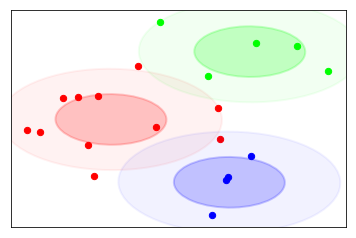

In [15]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)

ax1.scatter(x0[:,0],x0[:,1],c="#FF0000", s=40)
ax1.scatter(x1[:,0],x1[:,1],c="#00FF00", s=40)
ax1.scatter(x2[:,0],x2[:,1],c="#0000FF", s=40)
plot_ellipse(ax1,mu[0],sigma,"#FF0000")
plot_ellipse(ax1,mu[1],sigma,"#00FF00")
plot_ellipse(ax1,mu[2],sigma,"#0000FF")

### QDA Gaussian Mixture Estimates

For QDA we need to estimate again the per class marginal distributions
$$
    \hat{\pi}_k = \frac{\hat{N}_k}{N} = \frac{ \sum_i z_{i,k}}{N}
$$
the per class mean
$$
    \mu_{k,d} = \frac{1}{\hat{N}_k}=\sum_i z_{i,k}x_{i,d} 
$$
but we estimate a **per class** covariance matrix
$$
    \Lambda_{k,d,d'} = \frac{1}{\hat{N}_k} \sum_i z_{i,k}( x_{i,d} -\mu_{k,d})( x_{i,d'} -\mu_{k,d'})=\frac{1}{\hat{N}_k}\sum_i z_{i,k} x_{i,d}x_{i,d'} - \mu_{k,d}\mu_{k,d'}
$$

In [16]:
def QDA_estimate(X,Z):
    D=X.shape[1]
    counts=Z.sum(axis=0)
    pi=counts/len(X)
    ZX=Z[:,:,np.newaxis]*X[:,np.newaxis,:]
    mu=np.sum(ZX,axis=0)/counts[:,np.newaxis]
    print(ZX.shape,Z.shape,mu.shape)
    dX=ZX-Z[:,:,np.newaxis]*mu[np.newaxis,:,:]
    X2=dX[:,:,:,np.newaxis]*dX[:,:,np.newaxis,:]
    cov=X2.sum(axis=0)/counts[:,np.newaxis,np.newaxis]
    return pi,mu,cov

In [17]:
pi,mu,sigma=QDA_estimate(X,Z)
print("pi",pi)
print("mu",mu)
print("sigma",sigma)

(20, 3, 2) (20, 3) (3, 2)
pi [0.55 0.25 0.2 ]
mu [[-0.30440746  0.10799323]
 [ 1.88506622  2.66484143]
 [ 1.56300336 -2.26189515]]
sigma [[[ 0.96505804  0.0775804 ]
  [ 0.0775804   1.17348689]]

 [[ 0.90264845 -0.34271179]
  [-0.34271179  0.56758196]]

 [[ 0.04776841  0.16338976]
  [ 0.16338976  0.62477147]]]


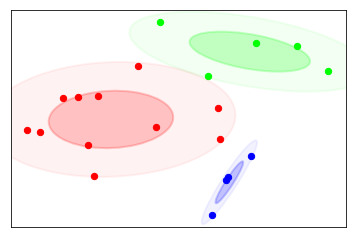

In [18]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)

ax1.scatter(x0[:,0],x0[:,1],c="#FF0000", s=40)
ax1.scatter(x1[:,0],x1[:,1],c="#00FF00", s=40)
ax1.scatter(x2[:,0],x2[:,1],c="#0000FF", s=40)
plot_ellipse(ax1,mu[0],sigma[0],"#FF0000")
plot_ellipse(ax1,mu[1],sigma[1],"#00FF00")
plot_ellipse(ax1,mu[2],sigma[2],"#0000FF")

## Classifiers

In [19]:
class LDAClassifier:
    def __init__(self):
        pass
    def fit(self,X,Y):
        # one-hot-encode
        K=Y.max()+1
        N=len(X)
        Z=np.zeros((N,K))
        Z[np.arange(N), Y] = 1
        self.pi,self.mu,self.sigma=LDA_estimate(X,Z)
    def predict(self,X):
        K=len(self.pi)
        N,D=X.shape
        prob=np.empty((N,K))
        for k in range(K):
             normal=multivariate_normal(mean=self.mu[k],cov=self.sigma)
             prob[:,k]=normal.pdf(X)*self.pi[k]
         
        Y=prob.argmax(axis=1)
        return Y

In [20]:
class QDAClassifier:
    def __init__(self):
        pass
    def fit(self,X,Y):
        # one-hot-encode
        K=Y.max()+1
        N=len(X)
        Z=np.zeros((N,K))
        Z[np.arange(N), Y] = 1
        self.pi,self.mu,self.sigma=QDA_estimate(X,Z)
    def predict(self,X):
        K=len(self.pi)
        N,D=X.shape
        prob=np.empty((N,K))
        for k in range(K):
             normal=multivariate_normal(mean=self.mu[k],cov=self.sigma[k])
             prob[:,k]=normal.pdf(X)*self.pi[k]
        #Y=np.zeros((N,K))
        #Y[np.arange(N), prob.argmax(axis=1)] = 1 
        Y=prob.argmax(axis=1)
        return Y

## Test Classifiers

### LDA

In [21]:
lda_model=LDAClassifier()
lda_model.fit(X,Y)
lda_model.sigma

array([[ 0.76599772, -0.01033078],
       [-0.01033078,  0.91226757]])

In [22]:
Y_lda_predicted=lda_model.predict(X_test)
np.average(Y_test==Y_lda_predicted)

0.9

Text(0.5,1,'Test Data Performance')

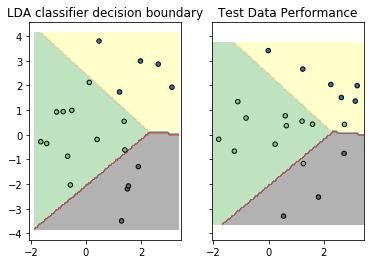

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
#plots.
plots.decision_boundary_2d(lda_model,X,Y,ax1,cmap=plt.cm.Accent)
ax1.set_title("LDA classifier decision boundary")
#plots.
plots.decision_boundary_2d(lda_model,X_test,Y_test,ax2,cmap=plt.cm.Accent)
ax2.set_title("Test Data Performance")
#fig.savefig('lda.png')

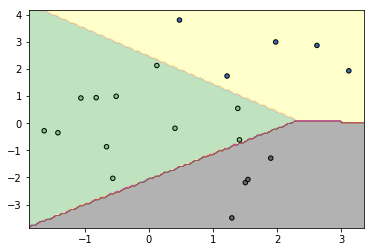

In [24]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
#plots.
plots.decision_boundary_2d(lda_model,X,Y,ax1,cmap=plt.cm.Accent)

### QDA

In [25]:
qda_model=QDAClassifier()
qda_model.fit(X,Y)
qda_model.sigma

(20, 3, 2) (20, 3) (3, 2)


array([[[ 0.96505804,  0.0775804 ],
        [ 0.0775804 ,  1.17348689]],

       [[ 0.90264845, -0.34271179],
        [-0.34271179,  0.56758196]],

       [[ 0.04776841,  0.16338976],
        [ 0.16338976,  0.62477147]]])

In [26]:
Y_qda_predicted=qda_model.predict(X_test)
np.mean(Y_test==Y_qda_predicted)

0.85

So QDA performance is slightly worse on this test.

Text(0.5,1,'Test Data Performance')

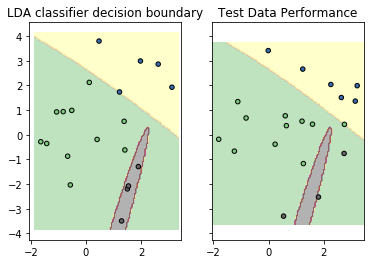

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
#plots.
plots.decision_boundary_2d(qda_model,X,Y,ax1,cmap=plt.cm.Accent)
ax1.set_title("LDA classifier decision boundary")
#plots.
plots.decision_boundary_2d(qda_model,X_test,Y_test,ax2,cmap=plt.cm.Accent)
ax2.set_title("Test Data Performance")
#fig.savefig('qda.png')

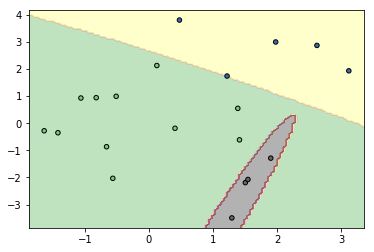

In [28]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(qda_model,X,Y,ax1,cmap=plt.cm.Accent)

## Comparison to `sklearn`

### LDA

In [29]:
sk_model=LDA()
sk_model.fit(X,Y)
np.mean(sk_model.predict(X_test)==Y_test)

0.9

### QDA

In [30]:
sk_model=QDA()
sk_model.fit(X,Y)
np.mean(sk_model.predict(X_test)==Y_test)

0.8

## Logistic Classifier

In [31]:
logistic_model=LogisticRegression(C=1e30, multi_class="multinomial",solver="sag")
logistic_model.fit(X,Y)
Y_pred=logistic_model.predict(X_test)
np.mean(Y_pred==Y_test)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.95

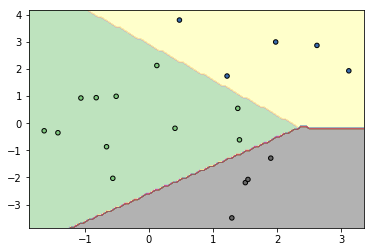

In [32]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(logistic_model,X,Y,ax1,cmap=plt.cm.Accent)

## Ellipsed Example

In [33]:
N = 40

X,Y=samples.ellipsoid(N//2)
X_test,Y_test=samples.ellipsoid(N) # we save away test date for later



(-10, 10)

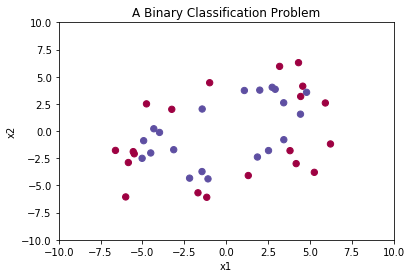

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.title("A Binary Classification Problem")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim([-10,10])
plt.ylim([-10,10])

In [35]:
model=LDAClassifier()
model.fit(X,Y)
np.mean(model.predict(X_test)==Y_test)

0.4875

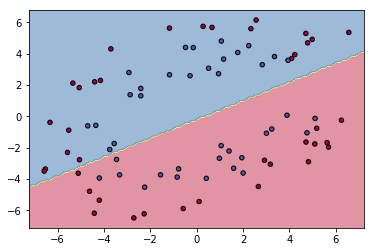

In [36]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(model,X_test,Y_test,ax1)
#ax1.set_title("LDA Test Performance")
#fig.savefig('overfitted.png')

In [37]:
model=QDAClassifier()
model.fit(X,Y)
np.mean(model.predict(X_test)==Y_test)

(40, 2, 2) (40, 2) (2, 2)


0.7375

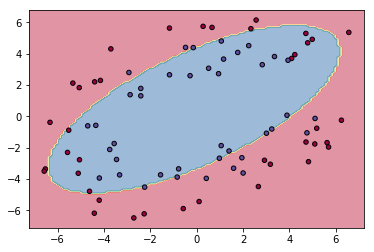

In [38]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(model,X_test,Y_test,ax1)
#ax1.set_title("QDA Test Performance")
#fig.savefig('overfitted.png')

### Comparison to Naive Bayes

In [39]:
model=GaussianNB()
model.fit(X,Y)
np.mean(model.predict(X_test)==Y_test)

0.85

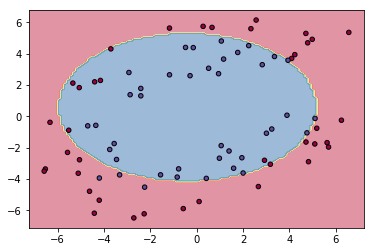

In [40]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(model,X_test,Y_test,ax1)